# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_12709/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        raise NotImplementedError

# Mean square error Loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (2 * (predicted - actual)) / len(actual)
    
# Binary cross entropy Loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted) - ((1 - actual) / (1 - predicted))) / len(actual))


### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Stocking the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(4)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs
        
        # Compute the feed forward pass
        """
        (b,i) @ (i,o) + (1,o) = (b,o)
        """
        return inputs @ self.params["w"] + self.params["b"]
        
     
        
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        """
        (i,b) @ (b,o) = (i,o)
        """
        self.grads["b"] = grad
        """
        (b,o) 
        """
        # Compute the feed backward pass
        """
        (b,o) @ (o,i) = (b,i)
        """
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))


# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad
    
    

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        self.lr = lr 
        """
        Learning rate
        """
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
                for name in layer.params.keys():
                    layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Class defining how to organize the data in series of batch

In [6]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])


class DataIterator:
    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        raise NotImplementedError

        
class BatchIterator(DataIterator):
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Defining the training routine of the network

In [7]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator(),
        num_epochs: int = 5000) -> None:

    Loss_list : Sequence = []
    Acc_list : Sequence = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        Predicted_list: Sequence = [] 
        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = []
            Batch_grad : Sequence = []
            Batch_acc : Sequence = []

            predicted = net.forward(batch[0])
            for i in predicted:
                Predicted_list.append(i)
            Batch_loss.append(loss.loss(predicted, batch[1]))
            grad = loss.grad(predicted, batch[1])
            Batch_grad.append(grad) 
            net.backward(grad)
            net.optimize()
                
            Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)

        Predicted_array = np.array(Predicted_list)   
            
        epoch_loss = np.mean(Batch_loss)
        epoch_acc = np.mean(Batch_acc)

        Loss_list.append(epoch_loss)
        Acc_list.append(epoch_acc)
                    
        # Print status every 100 iterations
        if epoch % 100 == 0:
            print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
        
    # print("Targets - Predictions - Results")
    # for y, z in zip(targets, Predicted_array):
    #     print(f'{y} => {z} => {z.round()}')
    
    plt.plot(Acc_list)
    plt.ylabel('Accuracy')
    plt.xlabel("Epochs:")
    plt.show()
    
    plt.plot(Loss_list)
    plt.ylabel('Loss')
    plt.xlabel("Epochs:")
    plt.show()


### Validation Process

In [8]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator()) -> None:
        
    Predicted_list: Sequence =[] 

    for batch in iterator(inputs, targets):

        Batch_loss : Sequence = []
        Batch_acc : Sequence = [] 

        predicted = net.forward(batch[0])
        for i in predicted:
                Predicted_list.append(i)
            
        Batch_loss.append(loss.loss(predicted, batch[1]))   
        Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)
   
    Predicted_array = np.array(Predicted_list)
        
    val_loss = np.mean(Batch_loss)
    val_acc = np.mean(Batch_acc)

    print(" Loss = ", val_loss," Acc = ", val_acc)
        
    # print("Targets - Predictions - Results")
    # for y, z in zip(targets, Predicted_array):
    #     print(f'{y} => {z} => {z.round()}')

    plt.hist(Predicted_array, histtype='step', bins=20)
    plt.xlabel("Predictions")
    plt.ylabel("Counts")
    plt.show()
   

In [9]:
lines: int = 20000

# 2 types of dataset : 12 variables and 3 variables

dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines)

dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines)


dataset1_validation = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines+1, nrows=lines)

dataset2_validation = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines+1, nrows=lines)



labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines)

labels_validation = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines+1, nrows=lines)

# New labels for binary cross entropy loss

bin_labels_train = np.where(labels_train.values == 0, 1, 0)

bin_labels_validation = np.where(labels_validation.values == 0, 1, 0)


Epoch =  0  Loss =  0.6447387894157833  Acc =  33.5
Epoch =  100  Loss =  0.27115226743671184  Acc =  65.0
Epoch =  200  Loss =  0.24406784526473513  Acc =  64.5
Epoch =  300  Loss =  0.22444779137432108  Acc =  70.5
Epoch =  400  Loss =  0.20312094856879948  Acc =  70.0
Epoch =  500  Loss =  0.2274250438120437  Acc =  74.5
Epoch =  600  Loss =  0.19615236733352215  Acc =  74.0
Epoch =  700  Loss =  0.17980916574568012  Acc =  78.0
Epoch =  800  Loss =  0.2120183117214853  Acc =  76.5
Epoch =  900  Loss =  0.2151895949290929  Acc =  71.0
Epoch =  1000  Loss =  0.15413490460780802  Acc =  78.0
Epoch =  1100  Loss =  0.24677543432099905  Acc =  75.5
Epoch =  1200  Loss =  0.1621243169080442  Acc =  77.5
Epoch =  1300  Loss =  0.20912206810276093  Acc =  74.0
Epoch =  1400  Loss =  0.1959159268640989  Acc =  75.0
Epoch =  1500  Loss =  0.1580111495795338  Acc =  79.0
Epoch =  1600  Loss =  0.1654240415701436  Acc =  80.0
Epoch =  1700  Loss =  0.19678278556323625  Acc =  72.0
Epoch =  180

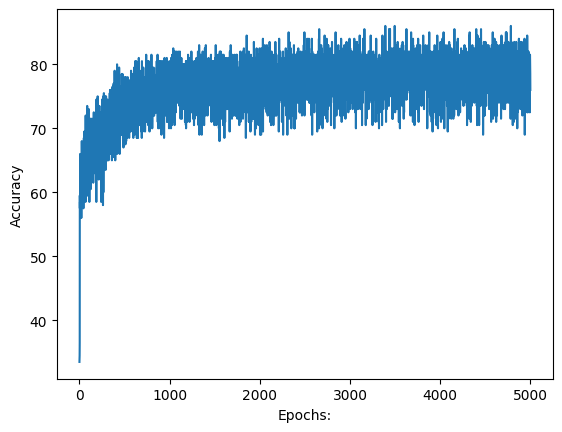

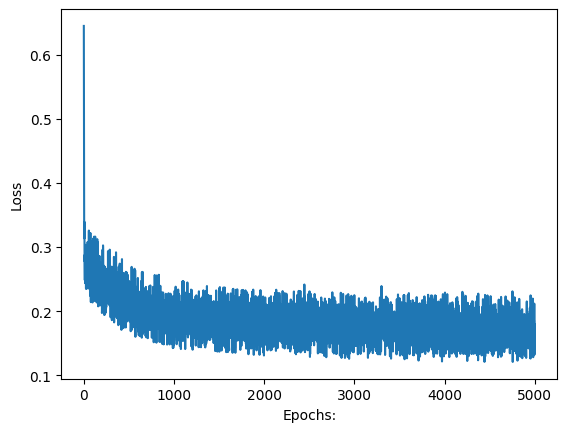

 Loss =  0.2681868426360365  Acc =  70.0


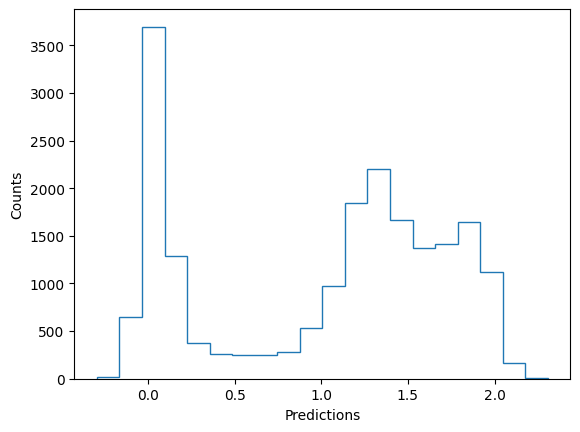

In [10]:
seed_value: bool = False
batch_num: int = 200

net1 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
])

train(net1, inputs=dataset1_train.values, targets=labels_train.values, loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num), num_epochs=5000)

validate(net1, inputs=dataset1_validation.values, targets=labels_validation.values, loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.6180535140866459  Acc =  69.5
Epoch =  100  Loss =  0.13371741542324828  Acc =  95.0
Epoch =  200  Loss =  0.14939261870444395  Acc =  94.0
Epoch =  300  Loss =  0.13822443642763188  Acc =  95.0
Epoch =  400  Loss =  0.1865516171546473  Acc =  93.0
Epoch =  500  Loss =  0.17410559497886202  Acc =  94.5
Epoch =  600  Loss =  0.14906554147449483  Acc =  93.0
Epoch =  700  Loss =  0.16144288400653534  Acc =  93.5
Epoch =  800  Loss =  0.09744270092744177  Acc =  95.0
Epoch =  900  Loss =  0.10568563283708535  Acc =  96.5
Epoch =  1000  Loss =  0.1253260302617553  Acc =  96.0
Epoch =  1100  Loss =  0.20881486117006975  Acc =  92.0
Epoch =  1200  Loss =  0.1042242794530976  Acc =  96.0
Epoch =  1300  Loss =  0.17418688113456543  Acc =  94.0
Epoch =  1400  Loss =  0.11998009838979447  Acc =  95.5
Epoch =  1500  Loss =  0.14873014425459288  Acc =  93.0
Epoch =  1600  Loss =  0.14193892257481905  Acc =  94.0
Epoch =  1700  Loss =  0.10421939055795551  Acc =  96.0
Epoch = 

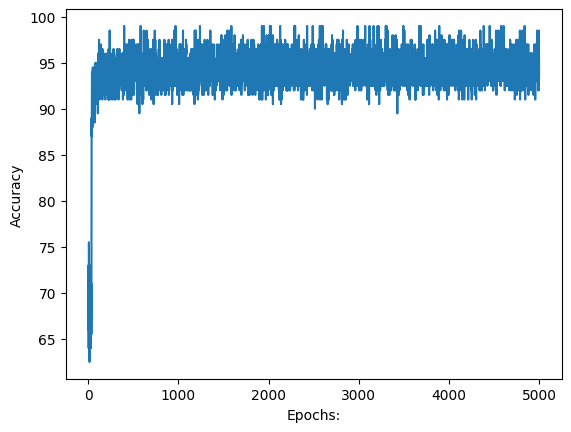

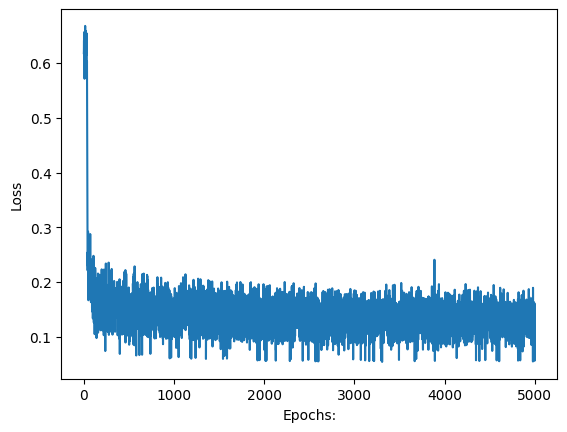

 Loss =  0.24325163428267588  Acc =  93.0


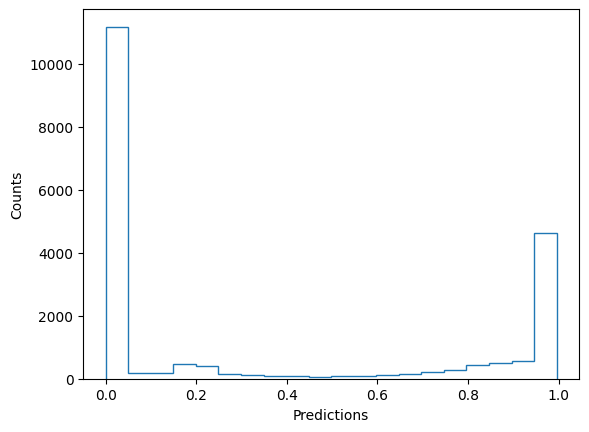

In [11]:
net2 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

train(net2, inputs=dataset1_train.values, targets=bin_labels_train, loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=5000)

validate(net2, inputs=dataset1_validation.values, targets=bin_labels_validation, loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))
